In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

In [2]:
mushroom_traindf = pd.read_csv("train.csv")
mushroom_testdf = pd.read_csv("test.csv")

# Subsample the training data
mushroom_traindf = mushroom_traindf.sample(frac=0.1, random_state=42)

In [3]:
mushroom_traindf.count()

id                      311694
class                   311694
cap-diameter            311694
cap-shape               311690
cap-surface             244437
cap-color               311693
does-bruise-or-bleed    311693
gill-attachment         259178
gill-spacing            185636
gill-color              311687
stem-height             311694
stem-width              311694
stem-root                36069
stem-surface            113645
stem-color              311692
veil-type                16011
veil-color               37678
has-ring                311693
ring-type               298879
spore-print-color        26584
habitat                 311691
season                  311694
dtype: int64

In [4]:
mushroom_traindf.dtypes

id                        int64
class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object

class: binary\
cap-diameter: numeric\
cap-shape: categorical\
cap-surface: categorical\
cap-color: categorical\
does-bruise-or-bleed: binary\
gill-attachment: categorical\
gill-spacing: categorical\
gill-color: categorical\
stem-height: numeric\
stem-width: numeric\
stem-root: categorical\
stem-surface: categorical\
stem-color: categorical\
veil-type: categorical\
veil-color: categorical\
has-ring: binary\
ring-type: categorical\
spore-print-color: categorical\
habitat: categorical\
season: categorical

In [5]:
# Dispaly percentage of data missing
missing_percentage_train = mushroom_traindf.isnull().mean() * 100

missing_percentage_train

id                       0.000000
class                    0.000000
cap-diameter             0.000000
cap-shape                0.001283
cap-surface             21.577894
cap-color                0.000321
does-bruise-or-bleed     0.000321
gill-attachment         16.848576
gill-spacing            40.442870
gill-color               0.002246
stem-height              0.000000
stem-width               0.000000
stem-root               88.428074
stem-surface            63.539561
stem-color               0.000642
veil-type               94.863231
veil-color              87.911862
has-ring                 0.000321
ring-type                4.111404
spore-print-color       91.471122
habitat                  0.000962
season                   0.000000
dtype: float64

In [6]:
missing_percentage_test = mushroom_testdf.isnull().mean() * 100

missing_percentage_test

id                       0.000000
cap-diameter             0.000337
cap-shape                0.001492
cap-surface             21.506821
cap-color                0.000626
does-bruise-or-bleed     0.000481
gill-attachment         16.834796
gill-spacing            40.404694
gill-color               0.002358
stem-height              0.000048
stem-width               0.000000
stem-root               88.452543
stem-surface            63.595327
stem-color               0.001011
veil-type               94.878689
veil-color              87.880445
has-ring                 0.000914
ring-type                4.148051
spore-print-color       91.417224
habitat                  0.001203
season                   0.000000
dtype: float64

In [7]:
# Remove any data where over 50% was missing
train_cleaned = mushroom_traindf.loc[:, missing_percentage_train < 50]
test_cleaned = mushroom_testdf.loc[:, missing_percentage_test < 50]

train_cleaned.head(), test_cleaned.head()

(              id class  cap-diameter cap-shape cap-surface cap-color  \
 1356763  1356763     p          7.82         s           t         r   
 2369311  2369311     p          3.20         o         NaN         g   
 1146527  1146527     e          9.36         f         NaN         n   
 889383    889383     p          6.52         s           d         e   
 416134    416134     p          3.13         b           t         n   
 
         does-bruise-or-bleed gill-attachment gill-spacing gill-color  \
 1356763                    t               d          NaN          g   
 2369311                    f               f            f          f   
 1146527                    t             NaN          NaN          w   
 889383                     t               d            c          w   
 416134                     f             NaN          NaN          n   
 
          stem-height  stem-width stem-color has-ring ring-type habitat season  
 1356763         4.49       13.30      

In [8]:
# Imputation and Encoding with remaining columns
columns_to_use = ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
                  'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
                  'stem-height', 'stem-width', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']

train_operations = mushroom_traindf[columns_to_use].copy()
test_operations = mushroom_testdf[columns_to_use].copy()

binary_cols = ['does-bruise-or-bleed', 'has-ring']
numeric_cols = ['cap-diameter', 'stem-height', 'stem-width']
categorical_cols = ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 
                    'gill-color', 'stem-color', 'ring-type', 'habitat', 'season']

# Imputing values
numeric_imputer = SimpleImputer(strategy='median')
train_operations.loc[:, numeric_cols] = numeric_imputer.fit_transform(train_operations[numeric_cols])
test_operations.loc[:, numeric_cols] = numeric_imputer.transform(test_operations[numeric_cols])

# Imputing categorical columns with 'most_frequent'
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_operations.loc[:, categorical_cols] = categorical_imputer.fit_transform(train_operations[categorical_cols])
test_operations.loc[:, categorical_cols] = categorical_imputer.transform(test_operations[categorical_cols])

train_operations['does-bruise-or-bleed'] = train_operations['does-bruise-or-bleed'].map({'f': 0, 't': 1}).astype('float64')
train_operations['has-ring'] = train_operations['has-ring'].map({'f': 0, 't': 1}).astype('float64')

test_operations['does-bruise-or-bleed'] = test_operations['does-bruise-or-bleed'].map({'f': 0, 't': 1}).astype('float64')
test_operations['has-ring'] = test_operations['has-ring'].map({'f': 0, 't': 1}).astype('float64')

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_operations[numeric_cols] = scaler.fit_transform(train_operations[numeric_cols])
test_operations[numeric_cols] = scaler.transform(test_operations[numeric_cols])

train_operations.head(), test_operations.head()

(         cap-diameter cap-shape cap-surface cap-color  does-bruise-or-bleed  \
 1356763      0.323480         s           t         r                   1.0   
 2369311     -0.668212         o           t         g                   0.0   
 1146527      0.654044         f           t         n                   1.0   
 889383       0.044433         s           d         e                   1.0   
 416134      -0.683237         b           t         n                   0.0   
 
         gill-attachment gill-spacing gill-color  stem-height  stem-width  \
 1356763               d            c          g    -0.688441    0.262955   
 2369311               f            f          f    -0.958314    0.739099   
 1146527               a            c          w     1.392911    1.438512   
 889383                d            c          w    -0.196754   -0.387116   
 416134                a            c          n     1.318973   -0.637523   
 
         stem-color  has-ring ring-type habitat season

In [10]:
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_encoded = one_hot_encoder.fit_transform(train_operations[categorical_cols])

test_encoded = one_hot_encoder.transform(test_operations[categorical_cols])

train_encoded_df = pd.DataFrame(train_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_cols))
test_encoded_df = pd.DataFrame(test_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_cols))

train_encoded_df.index = train_operations.index
test_encoded_df.index = test_operations.index

train_operations = pd.concat([train_operations.drop(categorical_cols, axis=1), train_encoded_df], axis=1)
test_operations = pd.concat([test_operations.drop(categorical_cols, axis=1), test_encoded_df], axis=1)

train_operations.head(), test_operations.head()

(         cap-diameter  does-bruise-or-bleed  stem-height  stem-width  \
 1356763      0.323480                   1.0    -0.688441    0.262955   
 2369311     -0.668212                   0.0    -0.958314    0.739099   
 1146527      0.654044                   1.0     1.392911    1.438512   
 889383       0.044433                   1.0    -0.196754   -0.387116   
 416134      -0.683237                   0.0     1.318973   -0.637523   
 
          has-ring  cap-shape_19.06  cap-shape_4.22  cap-shape_5.15  \
 1356763       0.0              0.0             0.0             0.0   
 2369311       0.0              0.0             0.0             0.0   
 1146527       1.0              0.0             0.0             0.0   
 889383        0.0              0.0             0.0             0.0   
 416134        1.0              0.0             0.0             0.0   
 
          cap-shape_6.44  cap-shape_7.21  ...  habitat_r  habitat_s  habitat_t  \
 1356763             0.0             0.0  ...     

In [11]:
# Using a dummy classifier
X_train = train_cleaned.drop('class', axis=1)
y_train = train_cleaned['class']

dummy = DummyClassifier(strategy="most_frequent")

dummy.fit(X_train, y_train)

X_test = test_cleaned.drop('id', axis=1)
test_predictions = dummy.predict(X_test)

In [12]:
submission = pd.DataFrame(
    {
        'id' : mushroom_testdf['id'],
        'class' : test_predictions
    }
)

submission.to_csv('submission.csv', index=False)

submission.head()

,id,class
0,3116945,p
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,p


In [13]:
# First real submission using a decision tree
X_train = train_operations.drop('class', axis=1, errors='ignore')
y_train = train_cleaned['class']

dt_train = DecisionTreeClassifier()
dt_train.fit(X_train, y_train)

DecisionTreeClassifier()

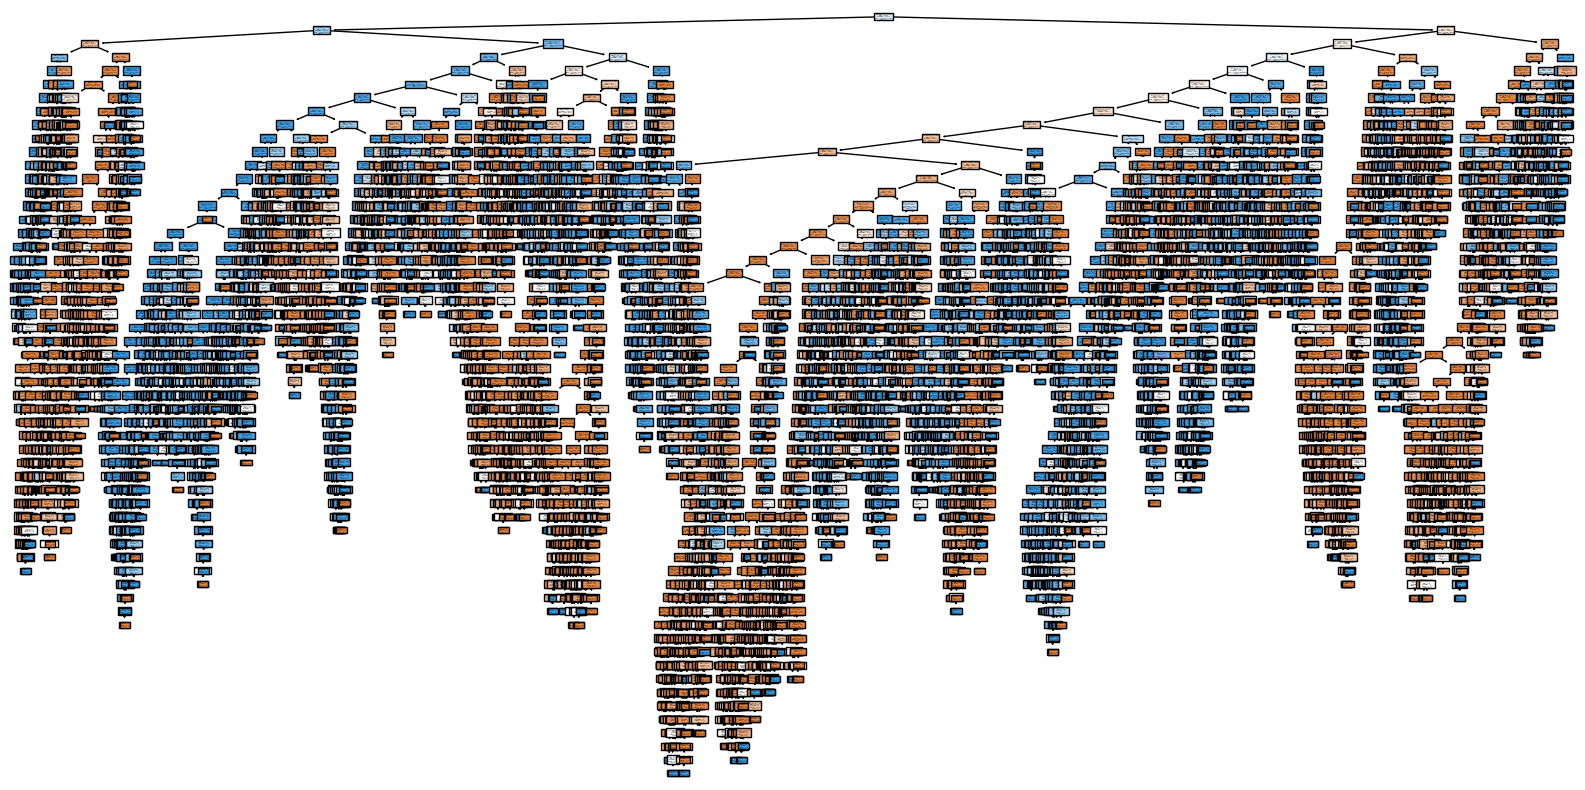

In [14]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dt_train, filled=True, feature_names=X_train.columns, class_names=dt_train.classes_)
plt.show()

In [15]:
cv_dt_train = cross_validate(dt_train, X_train, y_train, cv=10)

In [16]:
dt_test_predictions = dt_train.predict(test_operations)
submission1 = pd.DataFrame(
    {
        'id' : mushroom_testdf['id'],
        'class' : dt_test_predictions
    }
)

submission1.to_csv('submission1.csv', index=False)

submission1.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


In [17]:
# Impute missing values in X_train
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

gbt = GradientBoostingClassifier()

# Fit the model on the training data
gbt.fit(X_train_imputed, y_train)

# Impute missing values in test_operations
test_operations_imputed = imputer.transform(test_operations)

# Predict on the test data
gbt_test_predictions = gbt.predict(test_operations_imputed)
# gbt_test_predictions = gbt.predict(test_operations)

# Create a submission dataframe
submission_gbt = pd.DataFrame(
    {
        'id': mushroom_testdf['id'],
        'class': gbt_test_predictions
    }
)

# Save the submission to a CSV file
submission_gbt.to_csv('submission_gbt.csv', index=False)

# Display the first few rows of the submission
submission_gbt.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


In [18]:
# Impute missing values in X_train
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)

# Define hyperparameters for Randomized Search
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],  
    'subsample': [0.6, 0.8, 1.0]
}

gbt = GradientBoostingClassifier()

# Random search 1 time
random_search = RandomizedSearchCV(
    gbt,
    param_distributions=param_distributions,
    n_iter=1,
    scoring='accuracy',
    cv=3,
    random_state=42
)

# Fit model on training data
random_search.fit(X_train_imputed, y_train)

# Best parameters and estimator
print("Best Parameters:", random_search.best_params_)
best_gbt = random_search.best_estimator_

# cross-validation
cv_scores = cross_val_score(best_gbt, X_train_imputed, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", cv_scores.mean())

test_operations_imputed = imputer.transform(test_operations)

# Predict test data
gbt_test_predictions = best_gbt.predict(test_operations_imputed)

# Create submission dataframe
submission_gbt = pd.DataFrame(
    {
        'id': mushroom_testdf['id'],
        'class': gbt_test_predictions
    }
)

# Save submission to CSV file
submission_gbt.to_csv('submission_gbt_tune.csv', index=False)

# Display first few rows
print(submission_gbt.head())

Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2}
Cross-Validation Accuracy: 0.9872438981886285
        id class
0  3116945     e
1  3116946     p
2  3116947     p
3  3116948     p
4  3116949     e
